# Intro to CT (cosmotransitions)
(Updated 7/31/22)

So I guess first things first: documentation for the cosmotransitions package is [here](https://clwainwright.net/CosmoTransitions/) and the github repo is [here](https://github.com/clwainwright/CosmoTransitions).

The author (Wainwright) is not actively maintaining the package but nothing seems broken so far. 

## Overview
The package has a some high level functionality to compute transitions but mostly I think we just need the basic 1D instanton calculator, which goes by the name of `tunneling1D`. This module is our bread and butter to identify phase transitions and calculate and relevant quantities. The second module we need is `generic_potential` which we can subclass to define our potential and look for phase transitions.


This is everything we should need:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from cosmoTransitions import generic_potential
from cosmoTransitions import tunneling1D
#from cosmoTransitions import pathDeformation as pd

/opt/homebrew/lib/python3.9/site-packages/cosmoTransitions/finiteT.py:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(f1, 0, abs(theta)**.5)[0]


# Creating a model
So the first thing we want to do is subclass `generic_potential` so we can define a model. Note that this is using the coefficients from our previous paper `A`, `B`, and `C`. (Iʻve taken this directly from the docs so all comments are the authorʻs unless otherwise noted.)

In [3]:
class model1(generic_potential.generic_potential):
    """
    A sample model which makes use of the *generic_potential* class.

    This model doesn't have any physical significance. Instead, it is chosen
    to highlight some of the features of the *generic_potential* class.
    It consists of two scalar fields labeled *phi1* and *phi2*, plus a mixing
    term and an extra boson whose mass depends on both fields.
    It has low-temperature, mid-temperature, and high-temperature phases, all
    of which are found from the *getPhases()* function.
    """
    def init(self, a, b, c, Lambda, **kwargs):
        """
          m1 - tree-level mass of first singlet when mu = 0.
          m2 - tree-level mass of second singlet when mu = 0.
          mu - mass coefficient for the mixing term.
          Y1 - Coupling of the extra boson to the two scalars individually
          Y2 - Coupling to the two scalars together: m^2 = Y2*s1*s2
          n - degrees of freedom of the boson that is coupling.
        """
        # The init method is called by the generic_potential class, after it
        # already does some of its own initialization in the default __init__()
        # method. This is necessary for all subclasses to implement.

        # This first line is absolutely essential in all subclasses.
        # It specifies the number of field-dimensions in the theory.
        self.Ndim = 1
        self.deriv_order = 2
        self.Tmax = 10

        # This next block sets all of the parameters that go into the potential
        # and the masses. This will obviously need to be changed for different
        # models.
        self.a = a
        self.b = b
        self.c = c
        self.Lambda = Lambda

    def Vtot(self, X, T, include_radiation=True):
        """
        This method defines the tree-level potential. It should generally be
        subclassed. (You could also subclass Vtot() directly, and put in all of
        quantum corrections yourself).
        """
        # X is the input field array. It is helpful to ensure that it is a
        # numpy array before splitting it into its components.
        X = np.asanyarray(X)
        # x and y are the two fields that make up the input. The array should
        # always be defined such that the very last axis contains the different
        # fields, hence the ellipses.
        # (For example, X can be an array of N two dimensional points and have
        # shape (N,2), but it should NOT be a series of two arrays of length N
        # and have shape (2,N).)
        phi = X[...,0]
        
        # JACK NOTE: Here I wanted to avoid checking parameter space that we knew was not going to produce a 1st order PT
#         assert C < 0.5 + 9*B**2/(8*(1+4*A)), "no symmetry-breaking minimum"
#         assert C/(B+1e-12)**2 > 1, f"no phase transition; A {A}, B {B}, C {C}"
        
        return self.Lambda**4 * ((-0.5 + self.c * T**2)*phi**2 + self.b * T*phi**3 + (0.25 + self.a)*phi**4)

To compute our first phase transition, we need to define a specific model (by instantiating our class `model1`) and computing the PTs

In [11]:
params = {
    'Lambda': 1,
    'a': 0,
    'b': -1,
    'c': 2 
}

# define our model with params
m = model1(**params)

# find the transitions of our model
m.findAllTransitions();

# summarize the results
print('\n\n A summary of our results:')
m.prettyPrintTnTrans()

Tracing phase starting at x = [1.00000036] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
..................................
Tracing phase starting at x = [8.67361738e-19] ; t = 0.7658209102251978
Tracing minimum down
traceMinimum t0 = 0.765821
............................
Tracing minimum up
traceMinimum t0 = 0.765821
.............
Tunneling from phase 1 to phase 0 at T=0.5000002
high_vev = [8.67361738e-19]
low_vev = [1.50000006]
Path deformation converged. 1 steps. fRatio = 5.63914e-14
Tunneling from phase 1 to phase 0 at T=0.5005002
high_vev = [8.67361738e-19]
low_vev = [1.50016621]
Path deformation converged. 1 steps. fRatio = 5.67197e-14
Tunneling from phase 1 to phase 0 at T=0.6281545
high_vev = [8.67361738e-19]
low_vev = [1.49854853]
Path deformation converged. 1 steps. fRatio = 6.30024e-14
Tunneling from phase 1 to phase 0 at T=0.6919817
high_vev = [8.67361738e-19]
low_vev = [1.44050489]
Path deformation converged. 1 steps. fRatio = 5.78039e-14
Tunneling from phase 1 to phase 

So looking at the above results, we've got a 1st order PT occuring at temperature Tnuc=0.6736, the change in the vev is ~1.46, S=94.99, S/T=141.012. Unfortunately, some of the things we will need for the thermal parameters are not automatically printed out so we will have to try a little harder.

But first, a note: the method `findAllTransitions()` stores the information about the phase transitions in an attribute called `TnTrans`. `TnTrans` is a list of dictionaries. Each item in the list is a dictionary with information about a single phase transition (so in the event of more than one PT, `len(m.TnTrans)` is more than 0).

In [18]:
print('Our model has', len(m.TnTrans), 'phase transition(s)')
print('The information CT gives us about the PT is', m.TnTrans[0].keys())

Our model has 1 phase transitions
The information CT gives us about the PT is dict_keys(['low_vev', 'high_vev', 'Tnuc', 'low_phase', 'high_phase', 'instanton', 'action', 'trantype', 'crit_trans', 'Delta_rho', 'Delta_p'])


In [34]:
def get_profile(phi_vals, V_vals, guesses=(5, 0)):
    f = interpolate.UnivariateSpline(phi_vals, V_vals, s=0, k=4)
#     print(f(5))
    df = f.derivative(1)
    d2f = f.derivative(2)
    inst = tunneling1D.SingleFieldInstanton(*guesses, f, df, d2f)
    profile = inst.findProfile()
    action = inst.findAction(profile)
    
    return profile, action

## Scanning parameter space and calculating thermal parameters
Now, I'm just gonna go through the main idea of how to get thermal parameters (`betaH`, `ksi`, `Tnuc`) for a bunch of different potential parameters (`b`, `c`). There's gonna be a lot going on here and also I haven't touched much of this code since I wrote it a year ago so know that there is improvement to be done (especially with checking numerical problems which I gloss over here).

In [35]:
# Potential parameters that we want to scan over
bvals = np.linspace(-4, 0, num=25)
bvals 
cvals = np.linspace(0, 16, num=25)

# Fixed parameters
params['Lambda'] = 0.4 
gstar = 100

# Thermal parameters that we will derive (matrix with rows (first index) corresponding to b 
# and columns (second index) corresponding to c
# these values will be zero if CT chokes or the parameter space is invalid
Tnucs = np.zeros((len(bvals), len(cvals)))
betaHs = np.zeros((len(bvals), len(cvals)))
ksis = np.zeros((len(bvals), len(cvals)))

In [36]:
# %%capture capt
# we want to capture the output since CT really spits out a lot of info

# loop over b vals
for i, b in enumerate(bvals):
    # idr why I did this but looks like just shifting to the center of the b bin for some reason
    params['b'] = b + bvals[1] - bvals[0]
    # loop over c vals
    # note that our thermal parameter matrices will now be filled in, e.g., like ksis[i, j] = ...
    for j, c in enumerate(cvals):
        # ditto
        params['c'] = c + cvals[1] - cvals[0]
        
        # test the parameters, could put any restrictions we have on the potential here
        if c/b**2 < 1:
            print('bad b,c', c, b, c/b**2)
            continue
        
        # print progress and turn off verbosity to spew out fewer details from CT
        print(i, j)
        m = model1(**params)
        m.findAllTransitions(tunnelFromPhase_args={'verbose': False, 'fullTunneling_params': {'verbose': False}}); 
        m.prettyPrintTnTrans()
        
        # Store the nucleation temperature
        try:
            Tnuc = m.TnTrans[0]['Tnuc']
            Tnucs[i, j] = Tnuc
        # if it didn't work because there was no PT, just move on to the next values
        # Note: this is probably a place to be careful, I'm assuming that there actually 
        # isn't a PT, but there could be and CT is just having trouble with the numerics
        except IndexError:
            print('no Tnuc', m.TnTrans)
            continue
            
        # maybe it found a 2nd order PT, in this case, we will ignore it!
        if m.TnTrans[0]['trantype'] != 1:
            print('bad transition type', mn.TnTrans[0]['trantype'])
            continue

        # so now we have a FOPT with nucleation temp Tnuc, now we want to get a bit more info
        # we need to calculate the instanton for phi at various temperatures and take some derivatives using finite differences
        
        # we will calculate the potential at these field values (increase num to increase precision
        phis = np.linspace(-5, m.TnTrans[0]['low_vev']*2, num=20)
        # we will calculate the instanton at each of these temperatures (around Tnuc)
        Ts = np.linspace(Tnuc*0.999, Tnuc*1.001, num=20)
        # these are our initial guesses for the field minima (which should not be substantially far from those at Tnuc)
        # the fudge factors 1.01 and 0.99 are to ensure that tunneling1D can find these minima (i.e. they bound the region
        # that tunneling1D will look for minima), without fudge factors numerical hijinks can occur
        guesses = (m.TnTrans[0]['low_vev'][0]*1.01, m.TnTrans[0]['high_vev'][0]*0.99)
        
        # we will store all the details here
        profs, actions, good_Ts = [], [], []
        
        # loop through the temperatures
        for T in Ts:
            # get the potential at phis, T
            V_vals = m.Vtot(phis, T)
            try:
                # try to get the instanton profile and action
                profile, action = get_profile(phis, V_vals, guesses=guesses)
                profs.append(profile)
                actions.append(action)
                good_Ts.append(T)
            # if it fails...something is a little suss because we are very close to Tnuc, but sometimes things happen I guess
            except:
                print(f"Temperature {T} has no symmetry-breaking global minimum")
                pass
        
        # calculate thermal parameters
        # calculate beta
        ST = interpolate.UnivariateSpline(good_Ts, np.array(actions)/np.array(good_Ts), s=0, k=4)
        dSTdT = ST.derivative(1)
        betaH = dSTdT(Tnuc)/Tnuc
        betaHs[i, j] = betaH
        
        # calculate ksi
        # need to compute deltaV
        deltaVs = []

        # this is a little bit awkward, but we loop through each instanton calculated at different Ts
        # and we calculate deltaV between the two minima
        # the reshaping is just an awkward parsing of CT's output
        for T, prof in zip(good_Ts, profs):
            deltaV = m.Vtot(np.reshape(prof.Phi[-1], (1, 1)), T) - m.Vtot(np.reshape(prof.Phi[0], (1, 1)), T)
            deltaVs.append(deltaV)

        # compute the delV as a function of T
        delV = interpolate.UnivariateSpline(good_Ts, deltaVs, s=0, k=4)
        ddelVdT = delV.derivative(1)

        rho_n = np.pi**2 / 30 * gstar * Tnuc**4
        ksi = -1 / rho_n * (delV(Tnuc) - Tnuc * ddelVdT(Tnuc))
        
        ksis[i, j] = ksi
        
        print('done with', i * len(bvals) + c, '/', len(bvals) * len(cvals))
    
# write output to files should you so desire
with open('./cosmotrans_out.txt', 'w') as f:
    f.write(capt.stdout)
    f.write(capt.stderr)

bad b,c 0.0 -4.0 0.0
bad b,c 0.6666666666666666 -4.0 0.041666666666666664
bad b,c 1.3333333333333333 -4.0 0.08333333333333333
bad b,c 2.0 -4.0 0.125
bad b,c 2.6666666666666665 -4.0 0.16666666666666666
bad b,c 3.333333333333333 -4.0 0.20833333333333331
bad b,c 4.0 -4.0 0.25
bad b,c 4.666666666666666 -4.0 0.29166666666666663
bad b,c 5.333333333333333 -4.0 0.3333333333333333
bad b,c 6.0 -4.0 0.375
bad b,c 6.666666666666666 -4.0 0.41666666666666663
bad b,c 7.333333333333333 -4.0 0.4583333333333333
bad b,c 8.0 -4.0 0.5
bad b,c 8.666666666666666 -4.0 0.5416666666666666
bad b,c 9.333333333333332 -4.0 0.5833333333333333
bad b,c 10.0 -4.0 0.625
bad b,c 10.666666666666666 -4.0 0.6666666666666666
bad b,c 11.333333333333332 -4.0 0.7083333333333333
bad b,c 12.0 -4.0 0.75
bad b,c 12.666666666666666 -4.0 0.7916666666666666
bad b,c 13.333333333333332 -4.0 0.8333333333333333
bad b,c 14.0 -4.0 0.875
bad b,c 14.666666666666666 -4.0 0.9166666666666666
bad b,c 15.333333333333332 -4.0 0.9583333333333333
0 2

/var/folders/nw/tpsq99yd0j95pr58wn1kl8q80000gn/T/ipykernel_87055/541726692.py:15: RuntimeWarning: invalid value encountered in double_scalars
  if c/b**2 < 1:
/var/folders/nw/tpsq99yd0j95pr58wn1kl8q80000gn/T/ipykernel_87055/541726692.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  if c/b**2 < 1:


...............................
No transitions for this potential.

no Tnuc []
24 7
Tracing phase starting at x = [1.00000036] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
......................................
No transitions for this potential.

no Tnuc []
24 8
Tracing phase starting at x = [1.00000036] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
....................................
No transitions for this potential.

no Tnuc []
24 9
Tracing phase starting at x = [1.00000036] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
......................................
No transitions for this potential.

no Tnuc []
24 10
Tracing phase starting at x = [1.00000036] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
......................................
No transitions for this potential.

no Tnuc []
24 11
Tracing phase starting at x = [1.00000036] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.......................................
No transitions for this potential.

no Tnuc []
24 12

So that was a lot (and it takes like 4 min to sample 625 points of parameter space on my laptop) but we're basically done! Just got to plot:

/var/folders/nw/tpsq99yd0j95pr58wn1kl8q80000gn/T/ipykernel_87055/1711464087.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax[0].pcolormesh(bvals, cvals, Tnucs)
/var/folders/nw/tpsq99yd0j95pr58wn1kl8q80000gn/T/ipykernel_87055/1711464087.py:10: RuntimeWarning: divide by zero encountered in log10
  pc = ax[1].pcolormesh(bvals, cvals, np.log10(betaHs))
/var/folders/nw/tpsq99yd0j95pr58wn1kl8q80000gn/T/ipykernel_87055/1711464087.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error

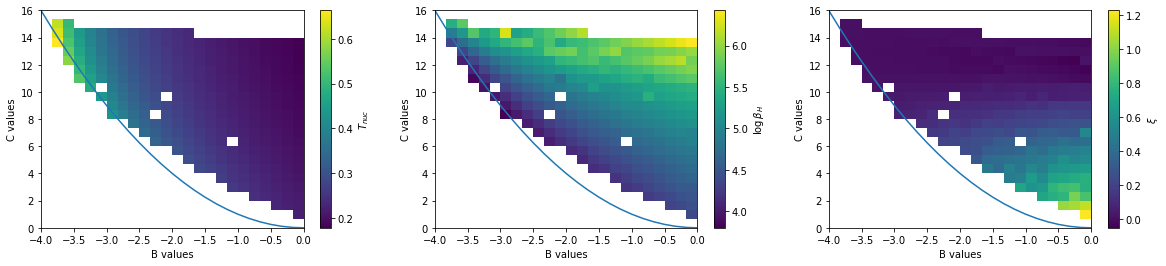

In [38]:
Tnucs[Tnucs == 0] = np.nan
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 4))
pc = ax[0].pcolormesh(bvals, cvals, Tnucs)
ax[0].set_ylabel('C values')
ax[0].set_ylim(top=cvals[-1])
ax[0].plot(bvals, bvals**2)
ax[0].set_xlabel('B values')
fig.colorbar(pc, label=r'$T_{nuc}$', ax=ax[0]);

pc = ax[1].pcolormesh(bvals, cvals, np.log10(betaHs))
ax[1].set_ylabel('C values')
ax[1].set_ylim(top=cvals[-1])
ax[1].plot(bvals, bvals**2)
ax[1].set_xlabel('B values')
fig.colorbar(pc, label=r'$\log\beta_H$', ax=ax[1]);

ksis[ksis == 0 ] = np.nan
pc = ax[2].pcolormesh(bvals, cvals, ksis)
ax[2].set_ylabel('C values')
ax[2].set_ylim(top=cvals[-1])
ax[2].plot(bvals, bvals**2)
ax[2].set_xlabel('B values')
fig.colorbar(pc, label=r'$\xi$', ax=ax[2]);

This isn't terrible! Definitely CT chokes at some points, but mostly it worked out. Also most of the thermal parameters seem to varying smoothly which seems good. For purposes of illustration though, I think this helps show how to use the program. In fact, I think mostly we can just tinker with the potential (in `model1`) and change the parameters we are scanning over. Some verification of the numerical precision and tolerances should probably be done too.